# Fourth assignment: Network Robustness

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import plotly 
plotly.tools.set_credentials_file(username='franco.danilo', api_key='ecMyRQ2GXo5ZASr8AgFu')

import plotly.plotly as py
import plotly.graph_objs as go

## 0. Failure utilities

In [130]:
def execute_failures2(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)

    diam_evol = [nx.diameter(workingG)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [len(workingG)]
    
    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)

        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)

        giant_evol.append(len(workingG))
        diam_evol.append(nx.diameter(workingG))
            
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def execute_failures(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    diam_evol = [nx.diameter(workingG)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [len(workingG)]
    
    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        if nx.is_connected(workingG):
            diam_evol.append(nx.diameter(workingG))
        else:
            diam_evol.append(0)
        
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        giant_evol.append(len(workingG))
         
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def plot_distribution(failDict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle("{} failures evolution".format(title))
 
    plt.subplot(121)
    plt.plot(failDict["Diameter evolution"], label="Diameter evolution")
    plt.plot(failDict["Average degree evolution"], label="Average degree evolution")
    plt.xlabel("#failures")
    plt.ylabel("value")
    plt.legend()
    plt.grid()

    
    plt.subplot(122)
    plt.plot(failDict["Giant component evolution"], label="Giant component evolution")
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    plt.legend()
    plt.grid()
    
def compare_attack(failDict, network):
    plt.figure(figsize=(15,8))
    plt.title("Evolution Comparison between different attack in a {} graph".format(network))
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    for attack, evolution in failDict.items():
        plt.plot(evolution, label=attack)
    plt.legend()
    plt.grid()
    
def compare_attack2(failDict, network):
    title = "Evolution Comparison between different attack in a {} graph".format(network)
    
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="#failures")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="GC size")
        )
    )
    
    data = []
    for attack, evolution in failDict.items():
        trace = go.Scatter(
            y=evolution,
            name=attack,
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

In [131]:
def random_ranking(graph):
    #return list(zip(np.random.permutation(graph.nodes()),range(1,graph.number_of_nodes()+1)))
    return np.random.choice(graph.nodes())

def metric_ranking(graph, metricFunction, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return max(metricDict.items(), key=lambda pair:pair[1])[0]

## 1. Erdős-Rényi random graph [$G_{np}$]
<h4><li>$p>\frac{\log{n}}{n}$ </li></h4>

In [141]:
n = 1000
attackDict = {}

In [142]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=7.742


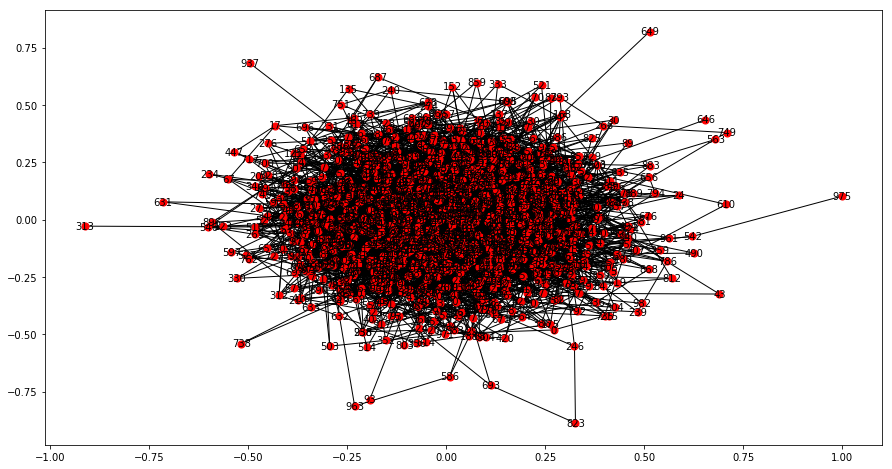

In [143]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [144]:
rand_failures = execute_failures(G, random_ranking)

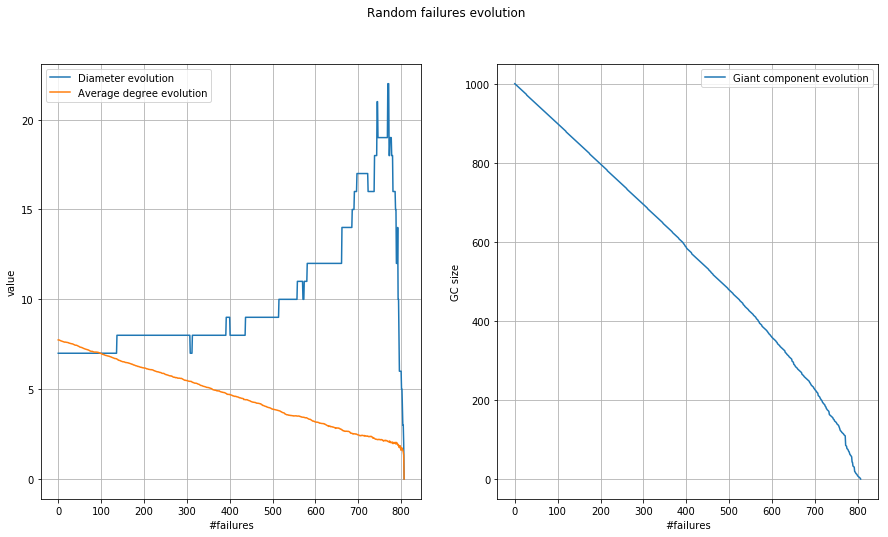

In [145]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [137]:
deg_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.degree})

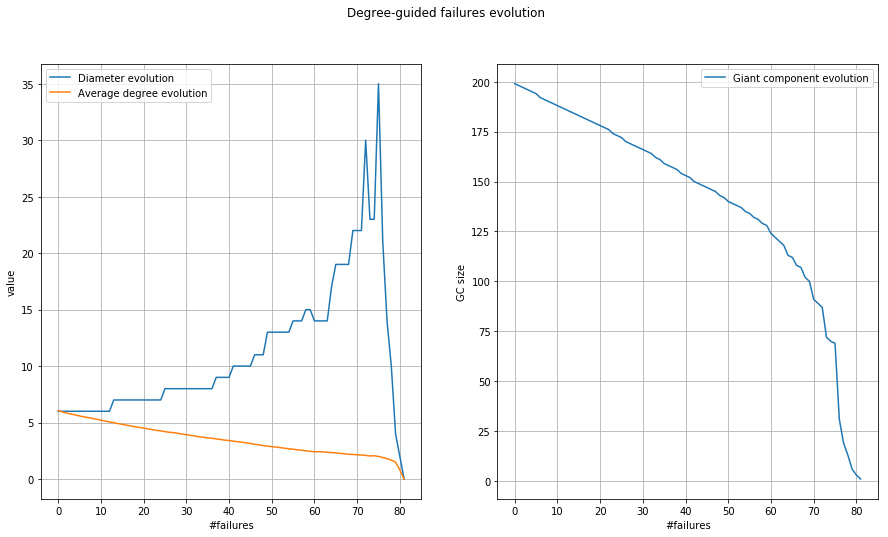

In [138]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over closeness

In [139]:
cls_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

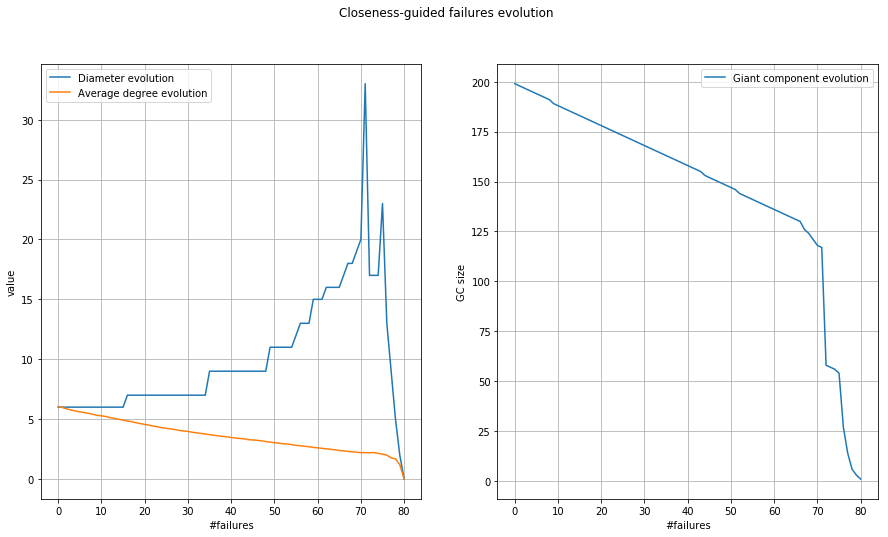

In [140]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [127]:
btw_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

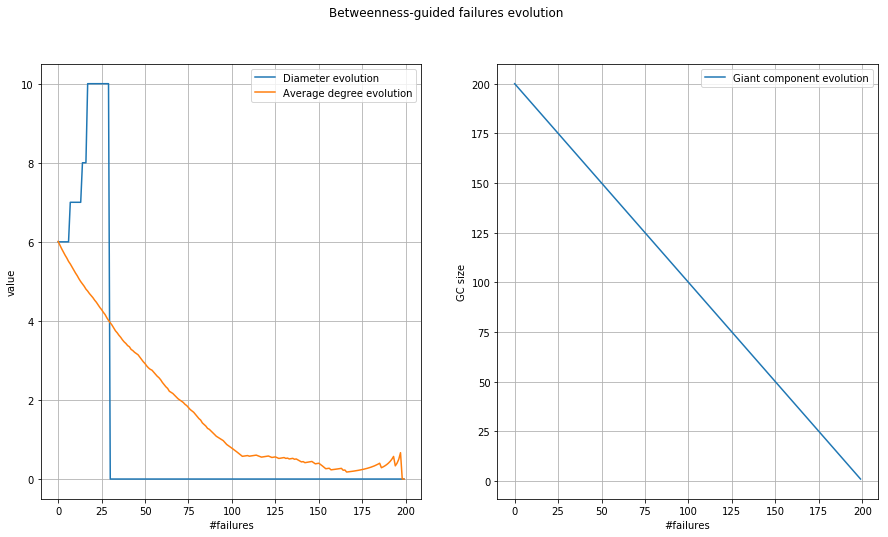

In [128]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [75]:
clt_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.clustering})

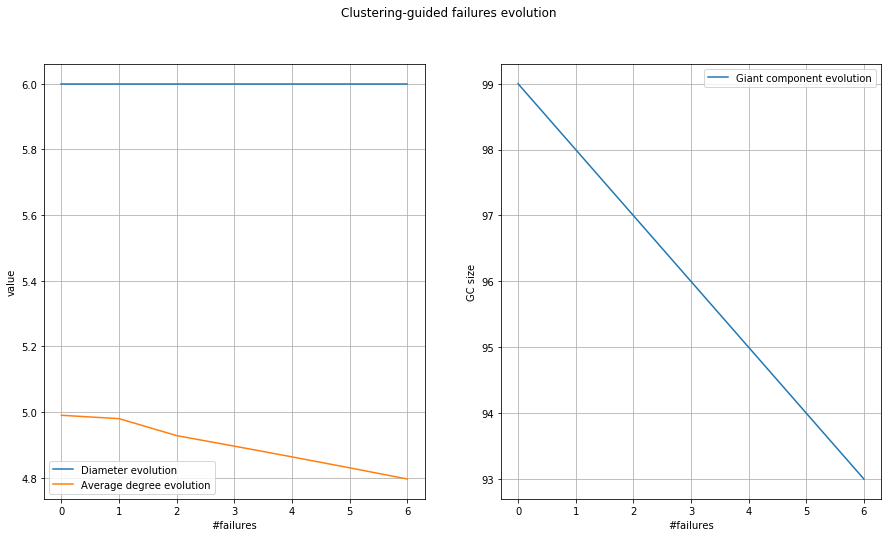

In [76]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [77]:
prk_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

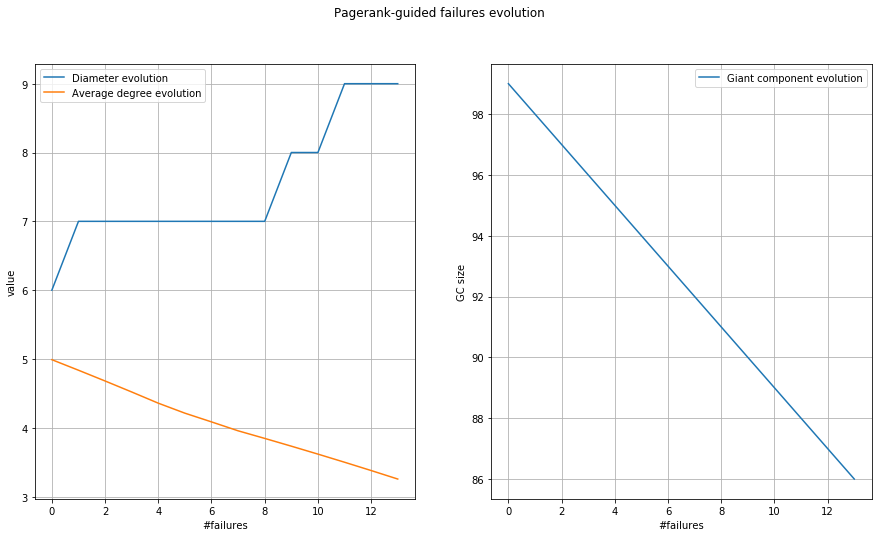

In [78]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [79]:
hit_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

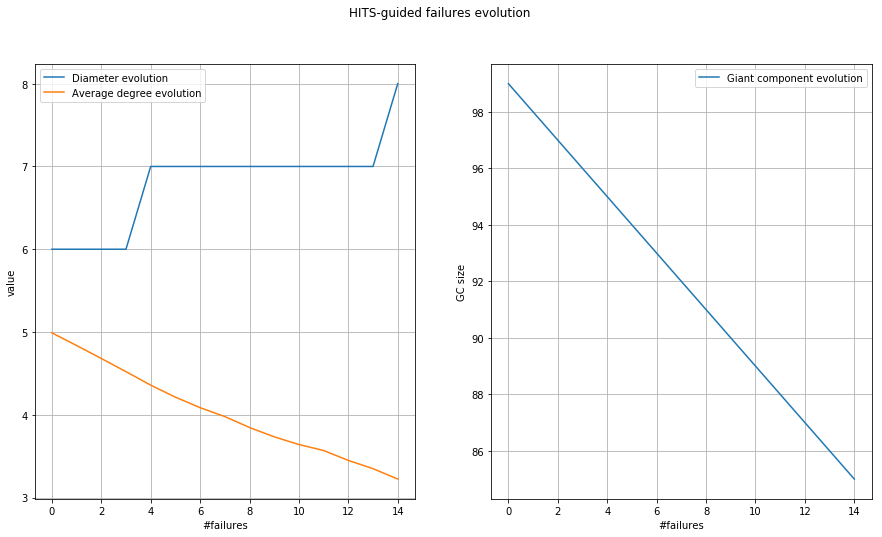

In [80]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

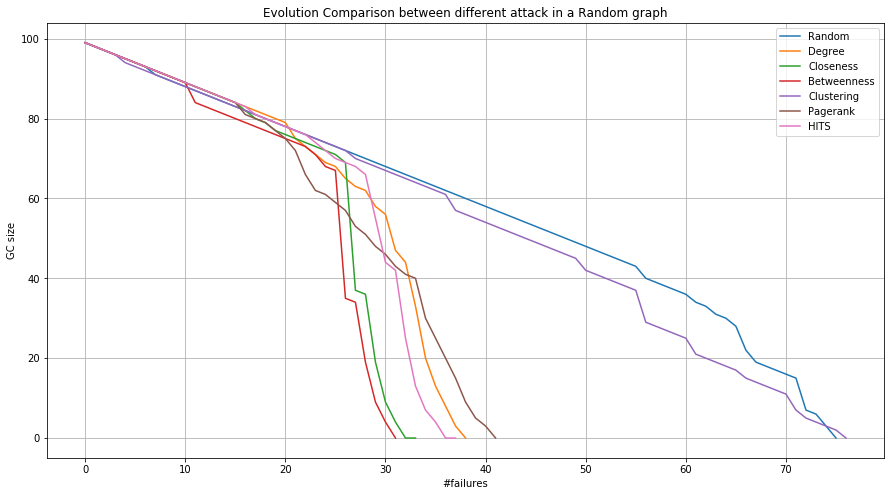

In [27]:
compare_attack(attackDict, "Random")

## 2. Power law network

In [81]:
n = 100
attackDict = {}

In [82]:
G = nx.barabasi_albert_graph(n,2)
pos = nx.spring_layout(G)
print("<k>={}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

<k>=3.92


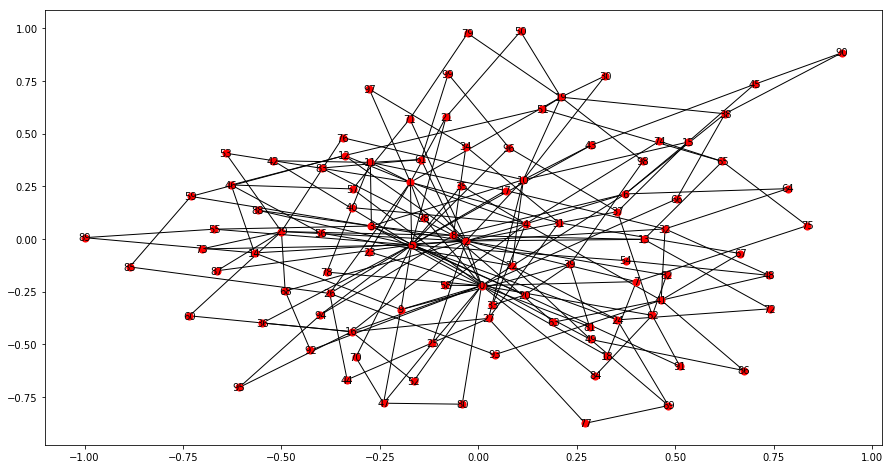

In [83]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [84]:
rand_failures = execute_failures(G, random_ranking)

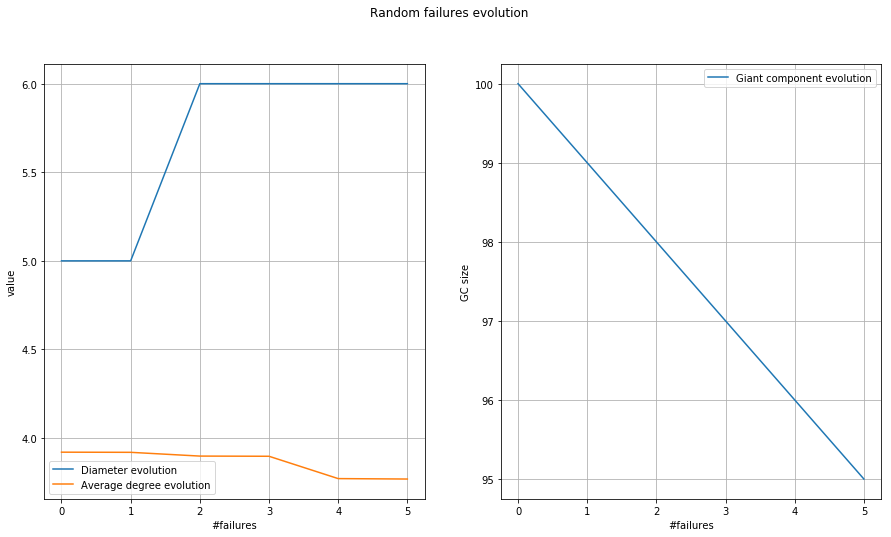

In [85]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [86]:
deg_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.degree})

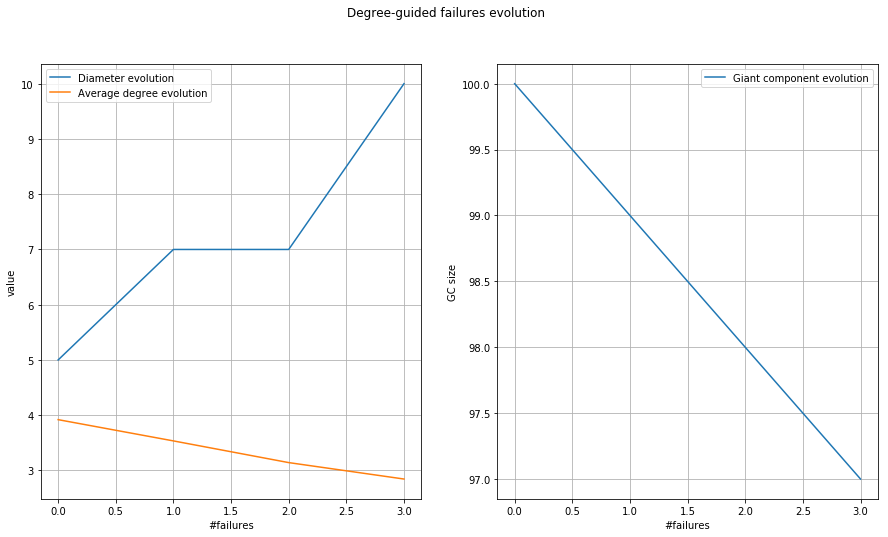

In [87]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over closeness

In [88]:
cls_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

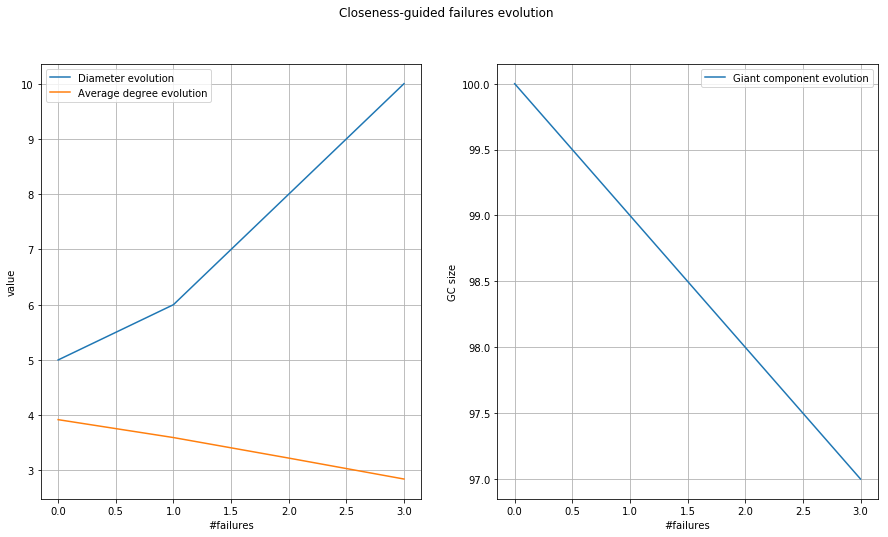

In [89]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [90]:
btw_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

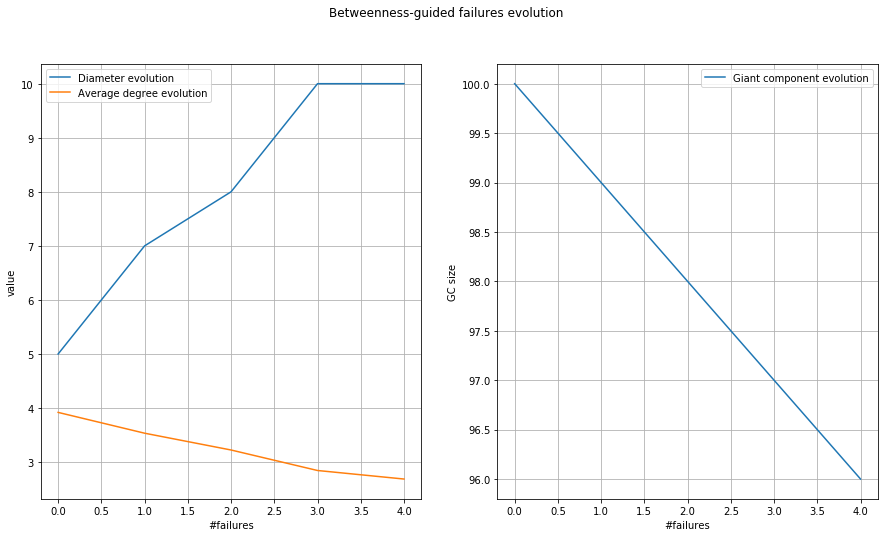

In [91]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [92]:
clt_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.clustering})

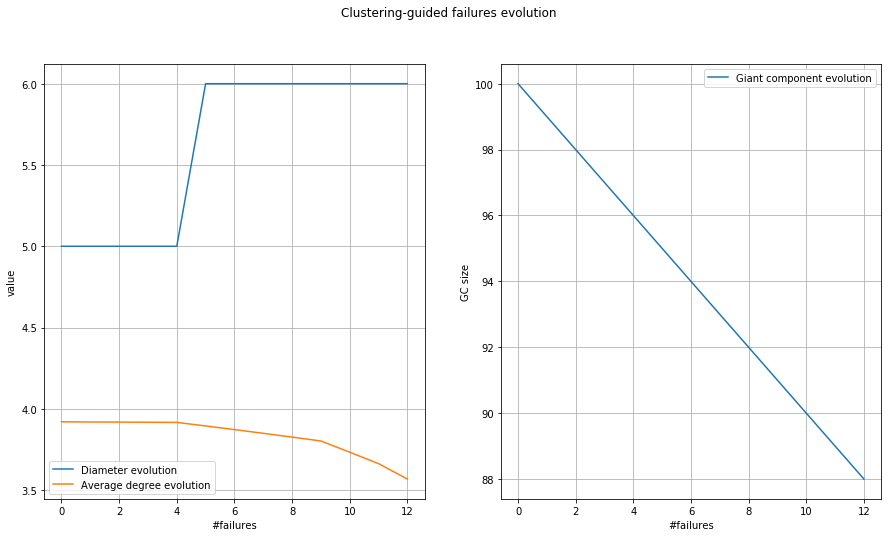

In [93]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [94]:
prk_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

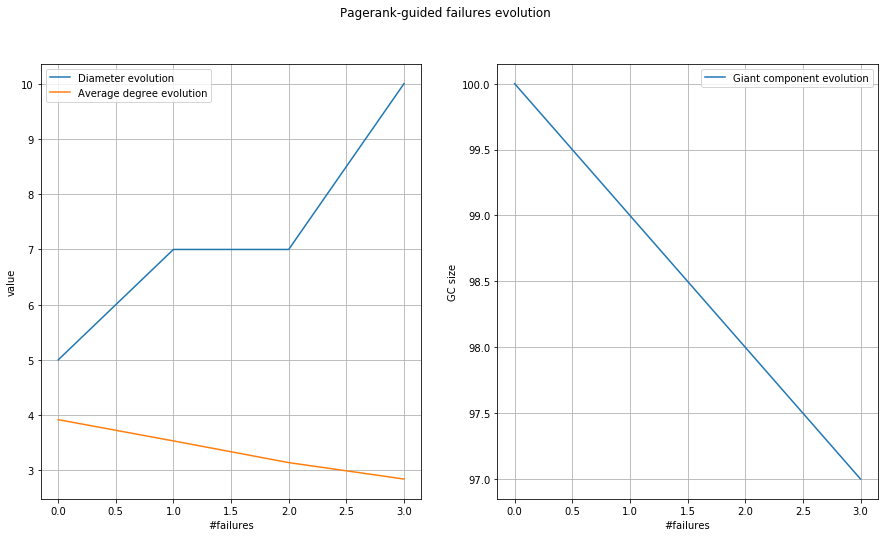

In [95]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [96]:
hit_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

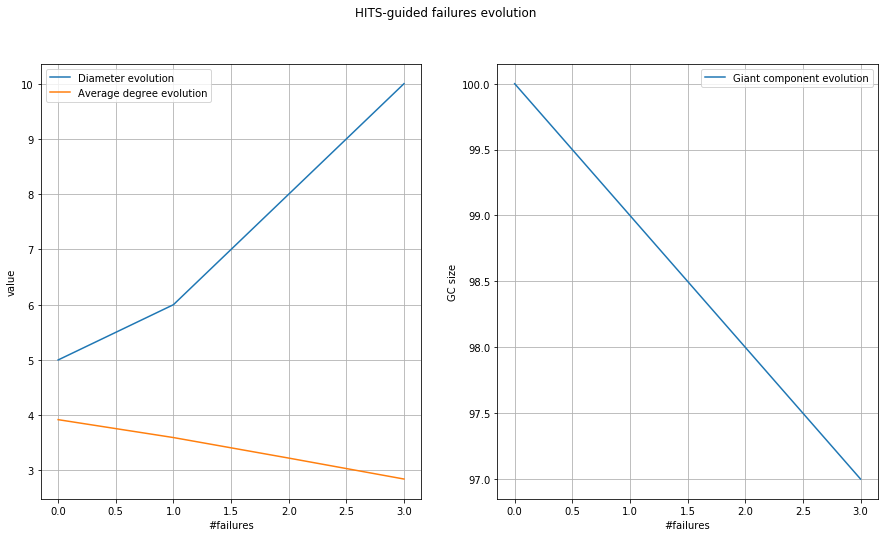

In [97]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

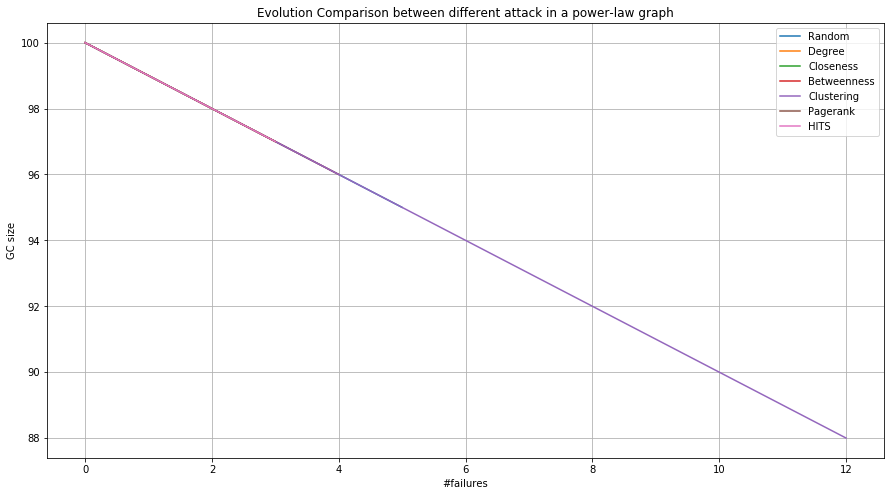

In [98]:
compare_attack(attackDict, "power-law")

## 3. Real Graph - arXiv collaboration on general relativity

In [ ]:
attackDict = {}

In [ ]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random failures

In [ ]:
rand_failures = execute_failures(G, random_ranking)

In [ ]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over nodes degree

In [ ]:
deg_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.degree})

In [ ]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over closeness

In [ ]:
cls_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

In [ ]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [ ]:
btw_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

In [ ]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over clustering coefficient

In [ ]:
clt_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.clustering})

In [ ]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prk_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

In [ ]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hit_failures = execute_failures(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

In [ ]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

In [ ]:
compare_attack(attackDict, "real")